# Example 1.E: Heavy Sampling of an Intricate Edge

We may sometimes have an edge that has fine details that need to be resolved by increasing the sampling parameter $n$, with the edge being sampled at $2n+1$ points, including the end points.

## When Things Go Right

For example, consider a unit square with one of the edges being sinusoidal.

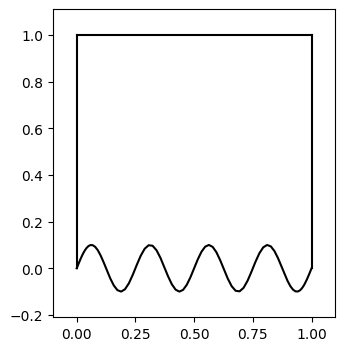

In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt

# define vertices
verts: list[pf.Vert] = []
verts.append(pf.Vert(x=0.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=1.0))
verts.append(pf.Vert(x=0.0, y=1.0))

# define edges
edges: list[pf.Edge] = []
edges.append(
    pf.Edge(
        verts[0],
        verts[1],
        pos_cell_idx=0,
        curve_type="sine_wave",
        amp=0.1,
        freq=8,
    )
)
edges.append(pf.Edge(verts[1], verts[2], pos_cell_idx=0))
edges.append(pf.Edge(verts[2], verts[3], pos_cell_idx=0))
edges.append(pf.Edge(verts[3], verts[0], pos_cell_idx=0))

# define mesh cell
K = pf.MeshCell(idx=0, edges=edges)

# parameterize edges
K.parameterize(quad_dict=pf.get_quad_dict(n=64))

# set up Nystrom solver
nyst = pf.NystromSolver(K)

# plot boundary
pf.plot.MeshPlot(K.get_edges()).draw()

Notice that the area of the mesh cell $K$ is $|K|=1$.
We could compute this by integrating the constant function $v=1$:
\begin{align*}
    1 = \int_K v^2~dx~.
\end{align*}

In [2]:
# define v to have a Dirichlet trace of 1 on each edge
one = pf.Polynomial([(1.0, 0, 0)])
v_trace = pf.PiecewisePolynomial(num_polys=4, polys=[one, one, one, one])

# the constant function v = 1 is harmonic
v = pf.LocalFunction(nyst=nyst, lap_poly=pf.Polynomial(), poly_trace=v_trace)
v.compute_all()

# compute area and error
area_exact = 1.0
area_computed = v.get_l2_inner_prod(v)
print(f"Error in computed area = {np.abs(area_exact - area_computed)}")

Error in computed area = 3.552713678800501e-15


## When Things Go Wrong

Let's make this example more interesting by increasing the frequency of the sinusoid on the bottom of the square.

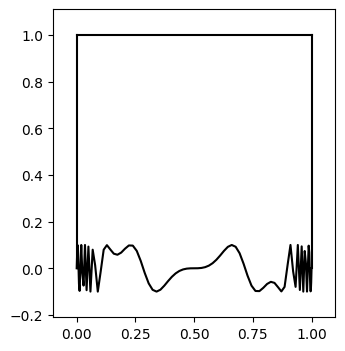

In [3]:
# crazy edge
edges[0] = pf.Edge(
    verts[0],
    verts[1],
    pos_cell_idx=0,
    curve_type="sine_wave",
    amp=0.1,
    freq=128,  # this is scary
)

# define and parameterize a new mesh cell
K = pf.MeshCell(idx=0, edges=edges)
K.parameterize(quad_dict=pf.get_quad_dict(n=64))

# and look at it
pf.plot.MeshPlot(K.get_edges()).draw()

That doesn't look right... 
We can change the sampling parameter $n$ when initializing a `MeshPlot` instance to get more resolution. We also need to set the `reparameterize` flag to `True`.

/Users/zkenyon/math/PuncturedFEM/puncturedfem/mesh/quad.py:114: UserWarning: Quad: n > 128 may cause numerical instability
  warn("Quad: n > 128 may cause numerical instability")


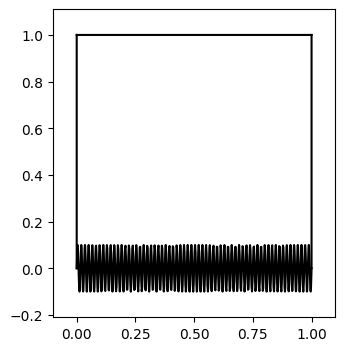

In [4]:
pf.plot.MeshPlot(K.get_edges(), reparameterize=True, n=512).draw()

That looks pretty good, but note that `MeshPlot` didn't overwrite the sampled points we got above with `n=64`:

In [5]:
print(f"n = {K.num_pts // K.num_edges // 2}")

n = 64


Since this is not a high enough sampling rate to capture the high frequency of the bottom edge, we might expect our computation of the area to not be very accurate.
Let's confirm this suspicion:

In [6]:
# set up Nystrom solver
nyst = pf.NystromSolver(K, verbose=True)

# the constant function v = 1
v = pf.LocalFunction(nyst=nyst, lap_poly=pf.Polynomial(), poly_trace=v_trace)
v.compute_all()

# compute area and error
area_exact = 1.0
area_computed = v.get_l2_inner_prod(v)
print(f"Error in computed area = {np.abs(area_exact - area_computed)}")

Setting up Nyström Solver... 512 sampled points on 4 Edges
Error in computed area = 1.1032616911524036


One might expect that if we increase the sampling parameter, this error will get smaller. 
However, we soon discover that this crashes the `NystromSolver` initialization.

In [7]:
# get 1024 sampled points on each edge
K.parameterize(quad_dict=pf.get_quad_dict(n=512))

# (WARNING!) this line will result in an exception being thrown
#nyst = pf.NystromSolver(K, verbose=True)

## Splitting Edges

As we saw in [Example 0](ex0-mesh-building.ipynb), we can split edges in two using the `split_edge()` function. Let's try splitting the 'bad' edge into smaller edges.

In [8]:
# split edge 0 in half
e1, e2 = pf.split_edge(e=edges[0], t_split=np.pi)
# split into quarters
e1_a, e1_b = pf.split_edge(e1, t_split=np.pi / 2)
e2_a, e2_b = pf.split_edge(e2, t_split=3 * np.pi / 2)

# replace edge 0 with quarter edges
edges += [e1_a, e1_b, e2_a, e2_b]
del edges[0]

# define mesh cell
K = pf.MeshCell(idx=0, edges=edges)

# bottom edge sampled at 1024 points
K.parameterize(quad_dict=pf.get_quad_dict(n=32))

# set up Nystrom solver
nyst = pf.NystromSolver(K, verbose=True)

Setting up Nyström Solver... 448 sampled points on 7 Edges


The `NystromSolver` didn't crash this time. 
Let's see if we can accurately compute the area:

In [9]:
# Dirichlet trace of constant function v = 1
v_trace = pf.PiecewisePolynomial(
    num_polys=K.num_edges, polys=K.num_edges * [one]
)

# constant function v = 1
v = pf.LocalFunction(nyst=nyst, lap_poly=pf.Polynomial(), poly_trace=v_trace)
v.compute_all()

# compute area and error
area_exact = 1.0
area_computed = v.get_l2_inner_prod(v)
print(f"Error in computed area = {np.abs(area_exact-area_computed)}")

Error in computed area = 8.628776804187055e-08
